## Packages

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.14

In [1]:
!pip install comet_ml
!pip install git+https://github.com/tensorflow/examples.git

     |████████████████████████████████| 315 kB 4.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 548 kB 39.0 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=c8c92a6969474fc5a0788087946bd4f6d1a56915f0af696ace9d2cd2289f9603
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-4_b3rs1s
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-4_b3rs1s
  Created wheel for tensorflow-examples: filename=tensorflow_examples-50872d6b8b4d5e071e90e34d00a33ac27fbf378a_-py3-none-any.whl size=268420 sha256=bf2d78486d141dd52bd1d1598c266d78760c925f1279610fa787cc3e9ef69adb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rsom8uxo/wheels/eb/19/50/2a4363c

## Imports

TODO: Signup for a free account at https://www.comet.ml and paste your API key below


In [ ]:
# Import Comet package for tracking the experiments

from comet_ml import Experiment
### TODO: Signup for a free account at https://www.comet.ml and paste your API key below
exp = Experiment(
    api_key="...",
    project_name='cyclegan-exercise')
### END OF TODO


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jecajeca/cyclegan-exercise/03531b22d243470f93864fcc62003b1b



In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Global variables

In [4]:
# Globals variables : 
img_width = 256
img_height = 256
batch_size = 1
buffer_size = 1000

## Utils functions (plotting, logging)
Take a look at TODOs ...


In [5]:
# Function to plot generated images : 
'''
Arguments : 
epoch - training epoch
generator - generator model from epoch epoch
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot
'''
def plot_generated_images(epoch, generator, dataset, exp, examples=25, dim=(5, 5), figsize=(5, 5), prefix='dataset'):
    #dataset = dataset.take(examples)
    # Generate images from created noise vector
    # Convert images into range [0-255] and convert to uint8 for proper plotting
    plt.figure(figsize=figsize)
    i = 0
    for real_img in dataset:
        gen_img = generator(real_img).numpy()
        gen_img = ((gen_img * 127.5) + 127.5).astype('uint8')
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(gen_img))
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig(prefix+'_gan_generated_image %d.png' % epoch)
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='generated_images_ep'+str(epoch)+'_'+prefix)
    plt.close()

# Function to plot real images : 
'''
Arguments : 
X_train - real dataset images (or batch of real dataset images)
exp - Comet.ml callback
examples - number of images to be plotted
dim - (rows, cols) of figure in which images will be plotted
figsize - size of the figure
prefix - prefix for the filename of the saved plot

'''
def plot_real_images(dataset, exp, examples=25, dim=(5, 5), figsize=(5, 5), prefix='dataset'):
    plt.figure(figsize=figsize)
    i = 0
    for real_img in dataset:
        real_img = ((real_img.numpy() * 127.5) + 127.5).astype('uint8')
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(np.squeeze(real_img))
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig(prefix+'_gan_real_image %d.png')
    # Log plotted figure into Comet.ml
    exp.log_figure(figure_name='real_images.png')
    plt.close()

# Comet logging gradinets distributions (vanishing gradients)
def get_gradients(gradmap, grads, model):
    for grad, param in zip(grads, model.trainable_variables):
        gradmap.setdefault(param.name, 0)
        gradmap[param.name] += grad

    return gradmap
def log_histogram(experiment, gradmap, step, prefix=None):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(v, name="%s/%s" % (prefix, k), step=step)


##  Dataset

In [6]:
# Load horse2zebra dataset
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

out_channels = 3

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1YA6Z0/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1YA6Z0/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1YA6Z0/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1YA6Z0/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [7]:
# The preprocessing function contains data augmentation usually used for the 
# training of CycleGAN (called random jitter), plus normalizing pixel values to [-1, 1]

def preprocess_image(image, label):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = tf.image.random_crop(
      image, size=[img_height, img_width, 3])
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  
  # normalizing the images to [-1, 1]
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1

  return image

In [8]:
# make training sets
train_horses = train_horses.cache().map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_horses = train_horses.shuffle(buffer_size)
train_horses = train_horses.batch(batch_size)

train_zebras = train_zebras.cache().map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_zebras = train_zebras.shuffle(buffer_size)
train_zebras = train_zebras.batch(batch_size)

## **CycleGAN model**


### Generator : 

Transforms an image from one dataset to the style of the other dataset.



In [9]:
def create_generator(out_channels=3):
  # In this example, we are using modified U-Net generator. 
  # In the original paper, modified ResNet generator is used.
  model = pix2pix.unet_generator(out_channels, norm_type='instancenorm')
  return model

In [10]:
# Test generator
generator_g = create_generator(out_channels=out_channels)
generator_f = create_generator(out_channels=out_channels)
generator_g.summary()
horse_img = list(train_horses.take(1))[0]
zebra_img = list(train_zebras.take(1))[0]
gen_zebra_img = generator_g(horse_img,training=False).numpy()
gen_horse_img = generator_f(zebra_img,training=False).numpy()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

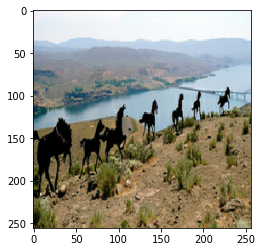

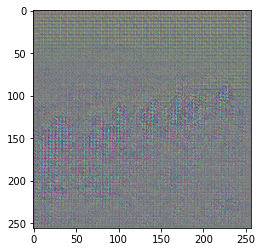

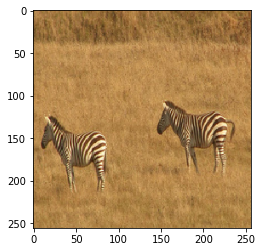

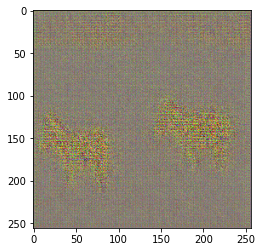

In [11]:
plot_img = np.squeeze(horse_img)
plt.imshow(((plot_img * 127.5) + 127.5).astype('uint8'))
plt.show()
plot_img = np.squeeze(gen_zebra_img)
plt.imshow(((plot_img * 127.5) + 127.5).astype('uint8'))
plt.show()
plot_img = np.squeeze(zebra_img)
plt.imshow(((plot_img * 127.5) + 127.5).astype('uint8'))
plt.show()
plot_img = np.squeeze(gen_horse_img)
plt.imshow(((plot_img * 127.5) + 127.5).astype('uint8'))
plt.show()

### Discriminator: 

The discriminator in CycleGAN is a convolutional PatchGAN classifier — it tries to classify if each image patch is real or not real.

The shape of the output after the last layer is (batch_size, 30, 30, 1).

Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.

Sigmoid will be added during loss calculation.



In [12]:
def create_discriminator():
    model = pix2pix.discriminator(norm_type='instancenorm', target=False)
    return model

In [13]:
# Test discriminator
discriminator_x = create_discriminator()
discriminator_y = create_discriminator()
discriminator_x.summary()
decision_horse = discriminator_x(gen_horse_img)
print(decision_horse.shape)
decision_zebra = discriminator_y(gen_zebra_img)
print(decision_zebra.shape)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    3072      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

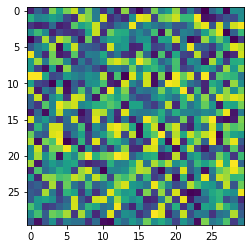

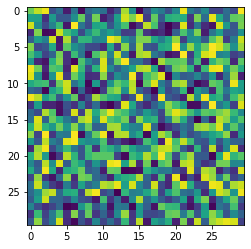

In [14]:
plot_img = np.squeeze(decision_horse.numpy())
plt.imshow(((plot_img* 127.5) + 127.5).astype('uint8'))
plt.show()
plot_img = np.squeeze(decision_zebra.numpy())
plt.imshow(((plot_img* 127.5) + 127.5).astype('uint8'))
plt.show()

### Loss functions and optimisers


In [15]:
#TODO: Create binary cross entropy loss function (use parameter from_logits = True because activation is linear in disciminator).
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#TODO: 
def discriminator_loss(disc_pred_for_real_data, disc_pred_for_generated_data):
  # (hint: disciminator should predict one for real data)
  real_loss = loss_function(tf.ones_like(disc_pred_for_real_data), disc_pred_for_real_data)
  # (hint: disciminator should  predict zero for real data)
  fake_loss = loss_function(tf.zeros_like(disc_pred_for_generated_data), disc_pred_for_generated_data)
  total_disc_loss = (real_loss + fake_loss)/2
  return total_disc_loss

#TODO: (hint: generator wants that discriminator's predictions are close to one for generated data)
def generator_loss(disc_pred_for_generated_data):
    gen_loss =  loss_function(tf.ones_like(disc_pred_for_generated_data), disc_pred_for_generated_data)
    return gen_loss

In [16]:
LAMBDA = 10

# Cycle loss - reconstruction loss, mean absolute error.
def cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [17]:
# Identity loss - If you run the zebra-to-horse model on a horse 
# or the horse-to-zebra model on a zebra, it should not modify the image much 
# since the image already contains the target class.

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [18]:
#Optimisers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Prepare models

In [19]:
# Log and plot progress (Comet.ml)
exp.get_callback('keras').set_model(generator_g)
exp.get_callback('keras').set_model(generator_f)

# GAN training

## Training step function

In [20]:
@tf.function
def train_step(real_images_x, real_images_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    generated_images_y = generator_g(real_images_x, training=True)
    # Generator F translates Y -> X.
    generated_images_x = generator_f(real_images_y, training=True)
    # Generated images need to be reconstructed back for cycle loss
    cycled_images_x = generator_f(generated_images_y, training=True)
    cycled_images_y = generator_g(generated_images_x, training=True)
    # For identity loss
    same_x = generator_f(real_images_x, training=True)
    same_y = generator_g(real_images_y, training=True)

    real_output_x = discriminator_x(real_images_x, training=True)
    real_output_y = discriminator_y(real_images_y, training=True)

    fake_output_x = discriminator_x(generated_images_x, training=True)
    fake_output_y = discriminator_y(generated_images_y, training=True)

    # calculate the loss for generators
    gen_g_loss = generator_loss(fake_output_y)
    gen_f_loss = generator_loss(fake_output_x)

    # Total cycle loss
    total_cycle_loss = cycle_loss(real_images_x, cycled_images_x) \
      + cycle_loss(real_images_y, cycled_images_y)

    # Total generator loss = adversarial loss + cycle loss + identity loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_images_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_images_x, same_x)

    # Discriminator loss
    disc_x_loss = discriminator_loss(real_output_x, fake_output_x)
    disc_y_loss = discriminator_loss(real_output_y, fake_output_y)

  # Get all gradients
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  

  # Update generators and discriminators
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss, generator_g_gradients, generator_f_gradients, discriminator_x_gradients, discriminator_y_gradients

## Training loop

In [21]:
def train(dataset_x, dataset_y, epochs):
  dataset_25_x = dataset_x.take(25)
  dataset_25_y = dataset_y.take(25)
  plot_real_images(dataset_25_x, exp, prefix='real_horses')
  plot_real_images(dataset_25_y, exp, prefix='real_zebras')
  cnt = 0
  gradmap_generator_f = {}
  gradmap_generator_g = {}
  gradmap_discriminator_x = {}
  gradmap_discriminator_y = {}

  for epoch in tqdm(range(epochs)):
    step=0
    for image_x, image_y in tf.data.Dataset.zip((dataset_x, dataset_y)):
      step = step+1
      gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, gen_g_grads, gen_f_grads, \
        disc_x_grads, disc_y_grads= train_step(image_x, image_y)

      # Logs for comet
      gradmap_generator_f = get_gradients(gradmap_generator_f, gen_f_grads, generator_f)
      gradmap_generator_g = get_gradients(gradmap_generator_g, gen_g_grads, generator_g)
      gradmap_discriminator_x = get_gradients(gradmap_discriminator_x, disc_x_grads, discriminator_x)
      gradmap_discriminator_y = get_gradients(gradmap_discriminator_y, disc_y_grads, discriminator_y)
      
      exp.set_step(cnt)
      exp.log_metric("disc_x_loss",disc_x_loss,step=cnt)
      exp.log_metric("disc_y_loss",disc_y_loss,step=cnt)
      exp.log_metric("gen_g_loss", gen_g_loss, step=cnt)
      exp.log_metric("gen_f_loss", gen_f_loss, step=cnt)
      cnt = cnt+1
     # scale gradients
    for k, v in gradmap_generator_g.items():
      gradmap_generator_g[k] = v / step
    for k, v in gradmap_generator_f.items():
      gradmap_generator_f[k] = v / step
    for k, v in gradmap_discriminator_x.items():
      gradmap_discriminator_x[k] = v / step
    for k, v in gradmap_discriminator_y.items():
      gradmap_discriminator_y[k] = v / step

    plot_generated_images(epoch, generator_g, dataset_25_x, exp, prefix='fake_zebras')
    plot_generated_images(epoch, generator_f, dataset_25_y, exp, prefix='fake_horses')
    log_histogram(exp, gradmap_generator_g,cnt, prefix="gradient_generator_g")
    log_histogram(exp, gradmap_generator_f,cnt, prefix="gradient_generator_f")
    log_histogram(exp, gradmap_discriminator_x,cnt, prefix="gradient_discriminator_x")
    log_histogram(exp, gradmap_discriminator_y,cnt, prefix="gradient_discriminator_y")


##Run code

In [22]:
train(train_horses, train_zebras, 10)

100%|██████████| 10/10 [2:32:13<00:00, 913.32s/it]


In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/mihailoobrenovic/cyclegan-exercise/886d4d10e9c548dda8f2bb9ad065102b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     disc_x_loss [10670] : (0.18034285306930542, 1.6308741569519043)
COMET INFO:     disc_y_loss [10670] : (0.08227021247148514, 1.7110142707824707)
COMET INFO:     gen_f_loss [10670]  : (1.3008272647857666, 12.770506858825684)
COMET INFO:     gen_g_loss [10670]  : (1.3880324363708496, 13.581293106079102)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1O8m-d7Q4Tgdk2Sh12FdRLXJCVaH6H718
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : False
COMET INFO:     Adam_beta_1        : 0.5
COMET INFO:     Adam_beta_2        : 0.999
COMET INFO:     Adam_decay         : 0.